In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

In [5]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")
tokenizer.pad_token = tokenizer.unk_token

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
C:\Users\suzuk\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
ds = load_dataset("fancyzhx/ag_news")


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [7]:
import numpy as np
np.unique(np.array(ds['train']['label']))

array([0, 1, 2, 3])

In [8]:
from transformers import OpenAIGPTLMHeadModel
model = OpenAIGPTLMHeadModel.from_pretrained("openai-gpt")
model

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

OpenAIGPTLMHeadModel(
  (transformer): OpenAIGPTModel(
    (tokens_embed): Embedding(40478, 768)
    (positions_embed): Embedding(512, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (lm_head): Linear(in_features=768, out_features=40478, bias=False)
)

In [12]:
data = iter(train_loader)
print(next(data))

(tensor([[16028,   481, 10407,  ...,     0,     0,     0],
        [35098,   478,  2186,  ...,     0,     0,     0],
        [ 7228, 18727,   500,  ...,     0,     0,     0],
        ...,
        [ 8725,   256,   252,  ...,     0,     0,     0],
        [ 6239,  2022,   240,  ...,     0,     0,     0],
        [16473,   280, 15761,  ...,     0,     0,     0]]), tensor([3, 0, 0, 3, 0, 3, 2, 2, 0, 3, 2, 3, 3, 2, 3, 0, 0, 1, 1, 3, 0, 0, 0, 2,
        1, 3, 0, 2, 2, 2, 3, 3, 2, 3, 2, 2, 1, 0, 1, 1, 3, 2, 3, 0, 1, 2, 0, 2,
        1, 3, 2, 0, 2, 2, 3, 2, 3, 0, 0, 0, 0, 0, 3, 3]))


C:\Users\suzuk\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [19]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = OpenAIGPTLMHeadModel.from_pretrained("openai-gpt")
    self.classifier = nn.Linear(40478, 4)

  def forward(self, x):
    x = self.encoder(x)
    x = self.classifier(x[0][:, -1, :])

    return x
      
model = TextClassifier()

In [20]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [21]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

train_loss = []
test_loss = []
lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch:3d} | Train Loss: {total_loss/len(train_loader)}")
  train_loss.append(total_loss)

  model.eval()
  with torch.no_grad():
    total_loss = 0.0
    for data in test_loader:  
        inputs, value = data
        inputs, value = inputs.to('cuda'), value.to('cuda')
        pred = model(inputs)
        loss = loss_fn(pred, value)
        total_loss += loss.item()
    test_loss.append(total_loss)
      

Epoch   0 | Train Loss: 28.764311731147767
Epoch   1 | Train Loss: 14.706931594276428
Epoch   2 | Train Loss: 15.230139890861512
Epoch   3 | Train Loss: 16.701809576479594
Epoch   4 | Train Loss: 16.100580627059937
Epoch   5 | Train Loss: 16.599574784342447
Epoch   6 | Train Loss: 15.192621718152363
Epoch   7 | Train Loss: 16.696097931543985
Epoch   8 | Train Loss: 17.289645918273926
Epoch   9 | Train Loss: 18.218883581638337


In [22]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.738 | Test acc: 0.737


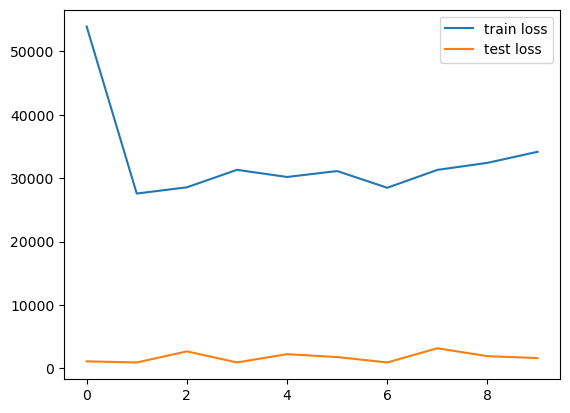

In [23]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()